In [1]:
#pip install altair

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tf.keras.utils.set_random_seed(42)
import altair as alt
import shap

# Used for displaying HTML
from IPython.display import display, HTML
import sys
import pickle


In [3]:
# Document Python version
from watermark import watermark

print(watermark())

Last updated: 2023-10-22T17:50:30.871495+00:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.15.0-1017-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [4]:
# import utility functions for the World Bank and OECD
sys.path.append("../utility_functions")
from world_bank_oecd_utility_functions import (
    get_indicator_name_from_code,
    get_indicator_definition_or_additional_info_from_code,
)

In [5]:
# import mapping dataframes for mapping the indicator code to the names, definitions and/or additional info
mapping_world_bank_to_names_and_definitions_df = pd.read_csv(
    "../WorldBankDatasets/Cleaned/World_Bank_Indicator_Definition_Info.csv",
    delimiter="\t",
)

# mapping dataframe for World Bank
mapping_df = mapping_world_bank_to_names_and_definitions_df

In [6]:
# OECD_model = keras.models.load_model('/oecd/NN_OECD_Model.h5')
WB_model = keras.models.load_model('world_bank/NN_WorldBank_Model.h5')

In [7]:
X_train = pd.read_csv('world_bank/X_train.csv')
y_train= pd.read_csv('world_bank/y_train.csv')
X_test= pd.read_csv('world_bank/X_test.csv')
y_test= pd.read_csv('world_bank/y_test.csv')
# Evaluate the model to get y_pred
y_pred = WB_model.predict(X_test)

8/8 [==============================] - 0s 1ms/step


In [8]:
# Load shap_values_test from the saved file that is computed in the modeling_feedforward_NN notebook
with open('shap_values_test.pkl', 'rb') as file:
    shap_values = pickle.load(file)

# Helper Functions

In [9]:
# This function allows you to pass in testing data (assuming you already had a trained model and outputted y_pred

# ⚠️ note we don't need X_train or y_train since they were used to make the model in another file
def get_residuals_df (X_test = X_test, y_test = y_test, y_pred = y_pred):

    # calculate the residuals (which are actual - predicted values)
    y_residuals = y_test - y_pred
    
    # create a new df with features, residuals and y_test present
    residuals_df = X_test.copy()
    residuals_df['y_residual'] = y_residuals.abs()
    residuals_df['y_actual'] = y_test
    
    # sort the values by absolute values
    residuals_df = residuals_df.sort_values('y_residual', ascending = False)
    
    return residuals_df

In [10]:
# This is one of the most useful functions. You will pass in shapley values, and it will output the top variable names
# that explain the model's output
def get_top_shapley_feature_names_from_shapley_values(shap_values, top_n_feature_values = 10, X_test=X_test):
    # Get the relevant 1D array. Initially assuming 1 row. This is needed otherwise an error might occur.
    #shap_values_1d = shap_values[0][0]

    # Convert the above 1D array to a dataframe.
    shap_df = pd.DataFrame([shap_values], columns=X_test.columns)

    # Pull the top shapley features
    top_feature_values = shap_df.iloc[0, :].sort_values(ascending=False)
    top_feature_values = top_feature_values.index

    # Display the top n feature values
    # top_feature_values = top_feature_values[:top_n_feature_values]

    # mapping top feature names with code only to their actual feature names
    top_feature_names_with_full_name = [
        get_indicator_name_from_code(code, mapping_df) for code in top_feature_values
    ]

    # Display the top n features names. Not giving indicator code. Actually giving the full name
    return top_feature_names_with_full_name[0:top_n_feature_values]

In [11]:
## Inputs
# data - one data column that should be visualized 
# title - graph title
# x_mark - x location of the outlier to flag respective to the overall distribution

def plot_distribution(data, title, x_mark):
    # Create a histogram of the data
    plt.hist(data, bins=30, color='blue', alpha=0.7, label= 'Distribution')

    # Mark the specific data point with a vertical line
    plt.axvline(x=x_mark, color='red', linestyle='--', label='Outlier value')

    # Add labels and legend
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()

    # Display the plot
    plt.show()

In [12]:
## Inputs
# df - dataframe with both X and y data present. y variable column name is simply 'y'
# column_name - the binary column name to use for color input

def binary_indicator_scatter_plot(df, column_name):
    # Create a scatter plot
    plt.figure(figsize=(10, 6))

    # Define two distinct colors for the binary indicator variable (0 and 1)
    colors = ['red', 'blue']

    # Create a scatter plot with the specified colors
    plt.scatter(df['Year'], df['y'], c=np.where(df[column_name] == 1, colors[1], colors[0]), alpha=0.7)

    # Add labels and title
    plt.xlabel('Year')
    plt.ylabel('Maternal Mortality')
    plt.title('Maternal Mortality vs. Year')

    # Create a custom color bar with labels
    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor=colors[0], markersize=10),
                     plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor=colors[1], markersize=10)]
    plt.legend(handles=custom_legend, title= column_name)

    # Display the plot
    plt.show()

In [13]:
## Inputs 
# df_train - dataframe with both X and y data present from train data. y variable column name is simply 'y'
# df_test - dataframe with both X and y data present from test data. y variable column name is simply 'y'
# country_to_plot - this is the country encoding (integer value)
# country_name - this is the country name as a string for the title

def country_scatter_plot(df_train, df_test, country_to_plot, country_name):
    # Filter the data for the selected country
    country_data_train = df_train[df_train['Country'] == country_to_plot]
    country_data_test = df_test[df_test['Country'] == country_to_plot]
    
    # Create a line plot for maternal mortality vs. year
    plt.figure(figsize=(10, 6))
    plt.plot(country_data_train['Year'], country_data_train['y'], marker='o', linestyle='-', color='b', label='Train Data')
    # Create a line plot for maternal mortality vs. year for test data as well
    plt.plot(country_data_test['Year'], country_data_test['y'], marker='o', linestyle='-', color='r', label='Test Data')
    # Create a line plot for maternal mortality vs. year for prediciton data as well
    plt.plot(country_data_test['Year'], country_data_test['y_pred'], marker='o', linestyle='-', color='g', label='Predictied Values')

    
    # Add labels and title
    plt.xlabel('Year')
    plt.ylabel('Maternal Mortality')
    plt.title(f'Maternal Mortality vs. Year for {country_name}')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

### Data handling, residuals, outliers and full train df

In [14]:
residuals_df = get_residuals_df()
top_10_outliers = residuals_df.iloc[0:10]
top_10_outliers

,Country,Year,SE.COM.DURS,SE.ENR.PRIM.FM.ZS,SE.ENR.PRSC.FM.ZS,SE.ENR.SECO.FM.ZS,SE.ENR.TERT.FM.ZS,SE.PRE.DURS,SE.PRE.ENRL,SE.PRE.ENRL.FE,...,TX.VAL.TECH.CD,TX.VAL.TECH.MF.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS,y_residual,y_actual
189,35,1989,0.222222,0.408295,0.397921,0.382958,0.504599,0.555556,0.094059,0.094967,...,0.008838,0.072788,0.509286,0.682406,0.571337,0.676593,0.552977,0.608583,30.824554,183.0
58,12,1995,0.333333,0.306204,0.707737,0.818025,0.625297,0.500000,0.005427,0.005371,...,0.003090,0.208097,0.316466,0.617191,0.436153,0.679701,0.534965,0.600458,28.139526,49.0
144,27,2009,0.555556,0.301508,0.453723,0.489809,0.982244,0.833333,0.007237,0.007069,...,0.001157,0.133882,0.258564,0.429191,0.303611,0.759077,0.432330,0.631131,27.220991,36.0
60,12,2003,0.333333,0.319970,0.607930,0.655613,0.937805,0.888889,0.005106,0.005030,...,0.003090,0.208097,0.166875,0.463059,0.276127,0.672894,0.348537,0.538619,19.491658,29.0
142,27,1994,0.444444,0.398371,0.710251,0.675059,0.763576,0.833333,0.004744,0.004694,...,0.007748,0.112283,0.339334,0.607688,0.441500,0.634522,0.445581,0.535962,19.098568,43.0
154,29,1985,0.555556,0.216278,0.259574,0.351698,0.013715,0.166667,0.000018,0.000000,...,0.002164,0.091127,0.674320,0.757281,0.699098,0.116849,0.668811,0.221364,17.605102,18.0
157,29,1998,0.555556,0.438674,0.455319,0.398544,0.623794,0.166667,0.000341,0.000321,...,0.005129,0.945134,0.637175,0.682674,0.639388,0.178426,0.591835,0.250283,16.257420,21.0
156,29,1995,0.555556,0.289805,0.270116,0.292043,0.524090,0.166667,0.000396,0.000370,...,0.005129,0.945134,0.652898,0.714398,0.664807,0.148274,0.620251,0.233483,16.132428,20.0
35,7,1999,0.555556,0.313212,0.523211,0.711320,0.730820,0.833333,0.007738,0.007655,...,0.008896,0.806062,0.276565,0.721868,0.470817,0.295069,0.669654,0.361219,14.988235,19.0
217,38,2001,0.333333,0.383964,0.551450,0.523613,0.807386,0.833333,0.005491,0.005353,...,0.055784,0.190369,0.193158,0.328768,0.216227,0.617480,0.249923,0.469572,14.522594,23.0


In [15]:
# Establish df's for all test and all train data

all_train = X_train.copy()
all_train['y'] = y_train

all_test = X_test.copy()
all_test['y'] = y_test
all_test['y_pred'] = y_pred

# Failure Analysis

In [16]:
## Country Codes for the top 3 outliers 
# 35 = ROU -- Romania
# 12 = EST -- Estonia
# 27 = LVA -- Latvia

## First Outlier with highest residual - Country Romania, Year 1989

Failure analysis: Second highest feature in terms of importance is an extreme outlier relative to the rest of the population across all nations. 

Future Improvement: Handling of outlier nations by better sampling methodologies

In [17]:
data_index = 189 # manually copied from top_10_outliers 

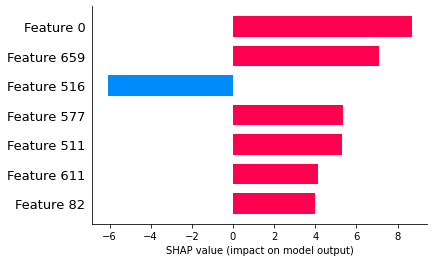

In [18]:
# look at the top outliers with shapley plots
shap.bar_plot(shap_values[data_index])

In [19]:
get_top_shapley_feature_names_from_shapley_values(shap_values[data_index])

['indicator name missing',
 'Incidence of tuberculosis (per 100,000 people)',
 'Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)',
 'Mortality rate, under-5, male (per 1,000 live births)',
 'Pupil-teacher ratio, secondary',
 'indicator name missing',
 'Fertility rate, total (births per woman)',
 'Prevalence of anemia among children (% of children ages 6-59 months)',
 'Employment in agriculture, female (% of female employment) (modeled ILO estimate)']

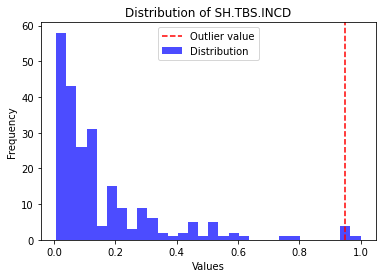

In [20]:
feature_index = 659

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][data_index]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

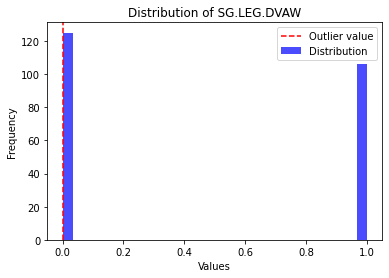

In [21]:
feature_index = 516

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][data_index]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

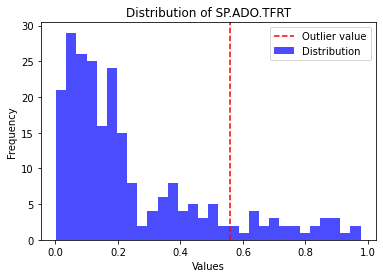

In [22]:
feature_index = 577

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][data_index]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

## Second Highest Residual Outlier, Country Estonia, Year 1995

Failure Analysis: Two of the top features are binary values indicating that there are bi-modal distributions for these two indicators. In one cases the indicator contains a strong time dependency and effectively only is relevant for more recent data points and the second shows a much narrower distribution for maternal mortality given a specific value. 

Future Improvement: Feature engineering - handling features with strong time correlation and .... 

In [23]:
data_index = 58 # manually copied from top_10_outliers 

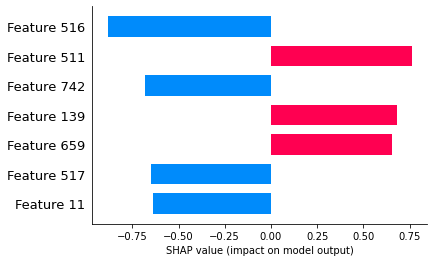

In [24]:
shap.bar_plot(shap_values[data_index])

In [25]:
get_top_shapley_feature_names_from_shapley_values(shap_values[data_index])

['Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)',
 'Percentage of enrolment in tertiary education in private institutions (%)',
 'Incidence of tuberculosis (per 100,000 people)',
 'Percentage of enrolment in pre-primary education in private institutions (%)',
 'Out-of-pocket expenditure per capita, PPP (current international $)',
 'Research and development expenditure (% of GDP)',
 'Population, male (% of total population)',
 'The law prohibits discrimination in employment based on gender (1=yes; 0=no)',
 'Mortality rate, adult, female (per 1,000 female adults)',
 'Domestic general government health expenditure per capita, PPP (current international $)']

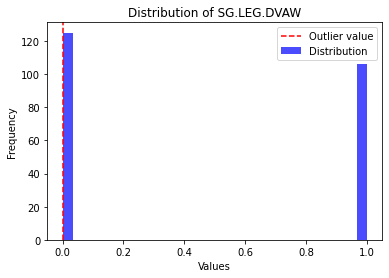

In [26]:
feature_index = 516

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][data_index]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

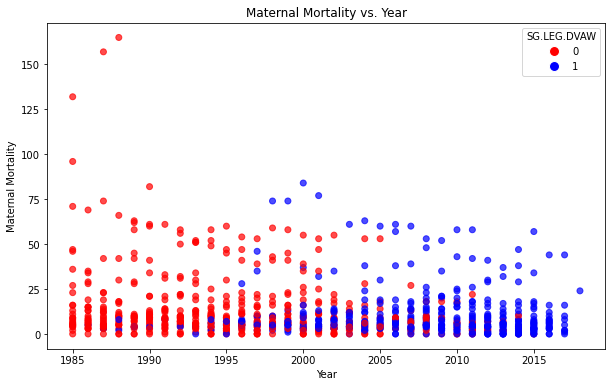

In [27]:
binary_indicator_scatter_plot(all_train, column_name)

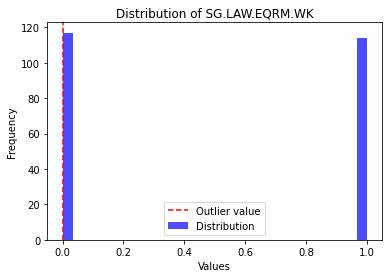

In [28]:
feature_index = 511

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][data_index]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

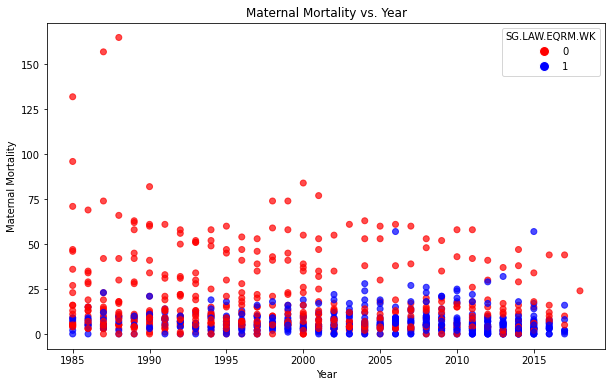

In [29]:
binary_indicator_scatter_plot(all_train, column_name)

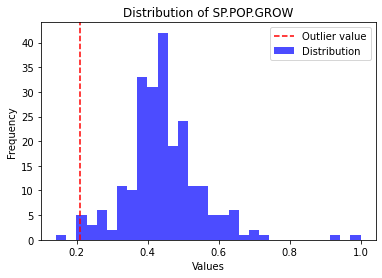

In [30]:
feature_index = 742

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][data_index]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

## Third Highest Residual Outlier, Country Latvia, Year 2009

Failure Analysis:  The model predicts a continually descending value for maternal mortality in this country despite a large fluctuation in the actual values represented in both the train and test data. Most other nations do exhibit this general trend and the large variation present for Latvia and the high feature weighting give to country mis-directs towards a smooth trend.

Future Improvement: Feature engineering? Better handling of country data with high variation and/or exploration of features that exhibit similar high variation 

In [31]:
data_index = 144 # manually copied from top_10_outliers 

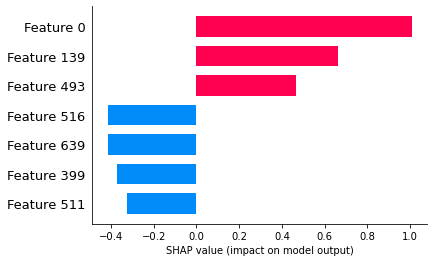

In [32]:
shap.bar_plot(shap_values[data_index])

In [33]:
get_top_shapley_feature_names_from_shapley_values(shap_values[data_index])

['indicator name missing',
 'Percentage of enrolment in tertiary education in private institutions (%)',
 'The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no)',
 'Population, male (% of total population)',
 'Research and development expenditure (% of GDP)',
 'Prevalence of HIV, total (% of population ages 15-49)',
 'Population, female (% of total population)',
 'Incidence of tuberculosis (per 100,000 people)',
 'Time-related underemployment, male (% of employment)',
 'Incidence of HIV, ages 15-49, female (per 1,000 uninfected female population ages 15-49)']

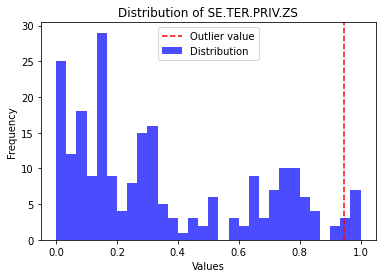

In [34]:
feature_index = 139

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][data_index]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

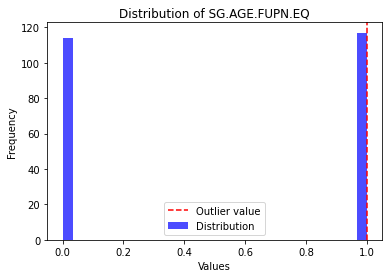

In [35]:
feature_index = 493

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][data_index]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

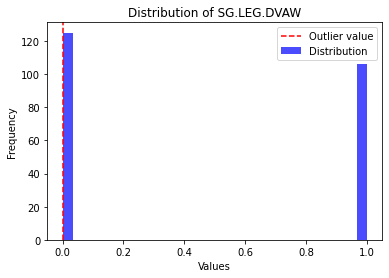

In [36]:
feature_index = 516

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][data_index]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

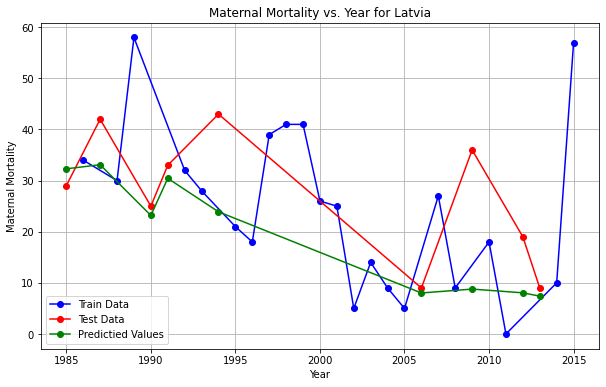

In [37]:
country_scatter_plot(all_train, all_test, 27, 'Latvia')

#### Do other countries also show this downward prediction trend despite volatile train data? 

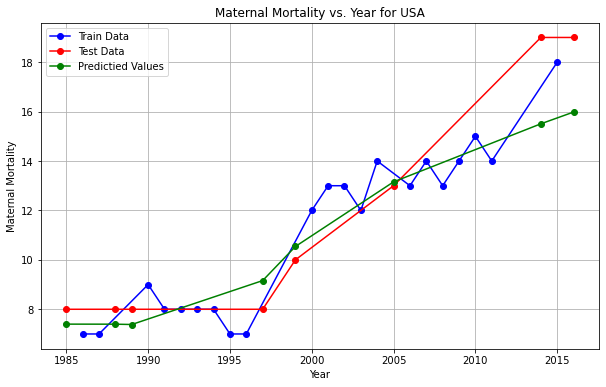

In [38]:
country_scatter_plot(all_train, all_test, 41, 'USA')

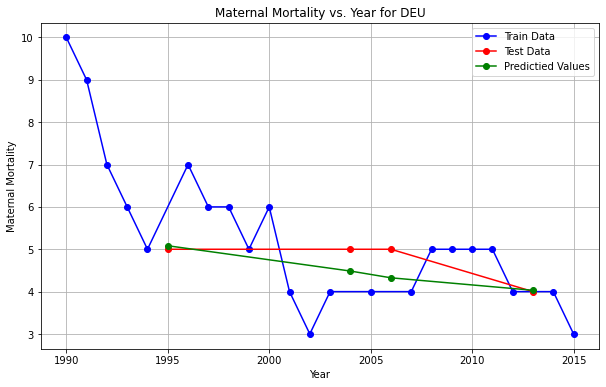

In [39]:
country_scatter_plot(all_train, all_test, 9, 'DEU')

# A look at country distribution 
Country is still encoded

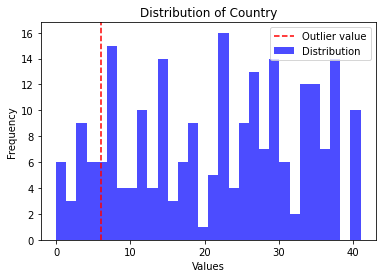

In [40]:
feature_index = 0

column_name = X_test.columns[feature_index]
x_mark = X_test[column_name][27]
plot_distribution(X_test[column_name], 'Distribution of ' + column_name, x_mark)

### Residuals by country with high frequency 

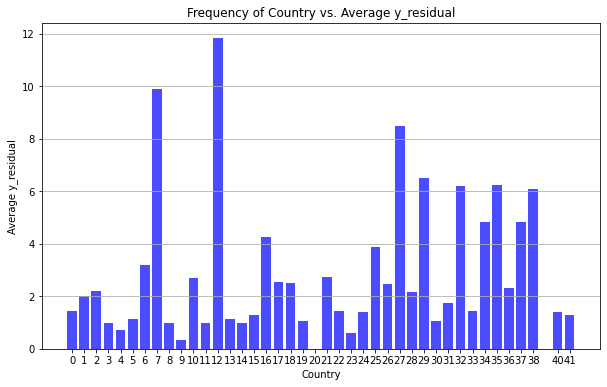

In [41]:
grouped = residuals_df.groupby('Country')['y_residual'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(grouped['Country'], grouped['y_residual'], color='blue', alpha=0.7)
plt.xlabel('Country')
plt.ylabel('Average y_residual')
plt.title('Frequency of Country vs. Average y_residual')
plt.xticks(grouped['Country'])
plt.grid(axis='y')

# Display the plot
plt.show()

In [42]:
# determine the frequency of each country and create a dictionary
country_counts = residuals_df['Country'].value_counts().to_dict()

# Map the counts to the 'Country' in the grouped DataFrame
grouped['Frequency'] = grouped['Country'].map(country_counts)

#grouped



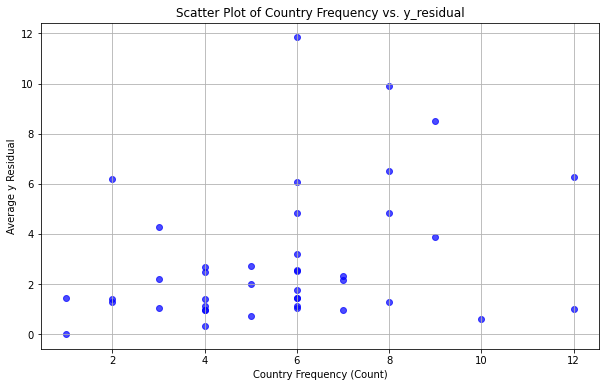

In [43]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(grouped['Frequency'], grouped['y_residual'], color='blue', alpha=0.7)
plt.xlabel('Country Frequency (Count)')
plt.ylabel('Average y Residual')
plt.title('Scatter Plot of Country Frequency vs. y_residual')
plt.grid(True)

# Display the plot
plt.show()

### Country Frequency represented in the train data 

In [44]:
# determine the frequency of each country and create a dictionary
train_country_counts = X_train['Country'].value_counts()

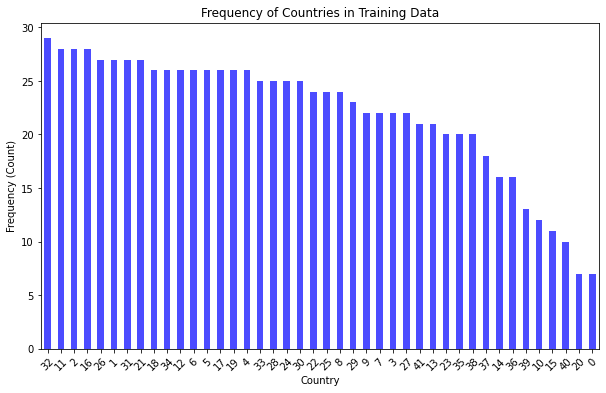

In [45]:
# Create a bar plot
plt.figure(figsize=(10, 6))
train_country_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel('Country')
plt.ylabel('Frequency (Count)')
plt.title('Frequency of Countries in Training Data')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the plot
plt.show()

In [46]:
## Country Codes for the top 3 outliers 
# 35 = ROU -- Romania
# 12 = EST -- Estonia
# 27 = LVA -- Latvia

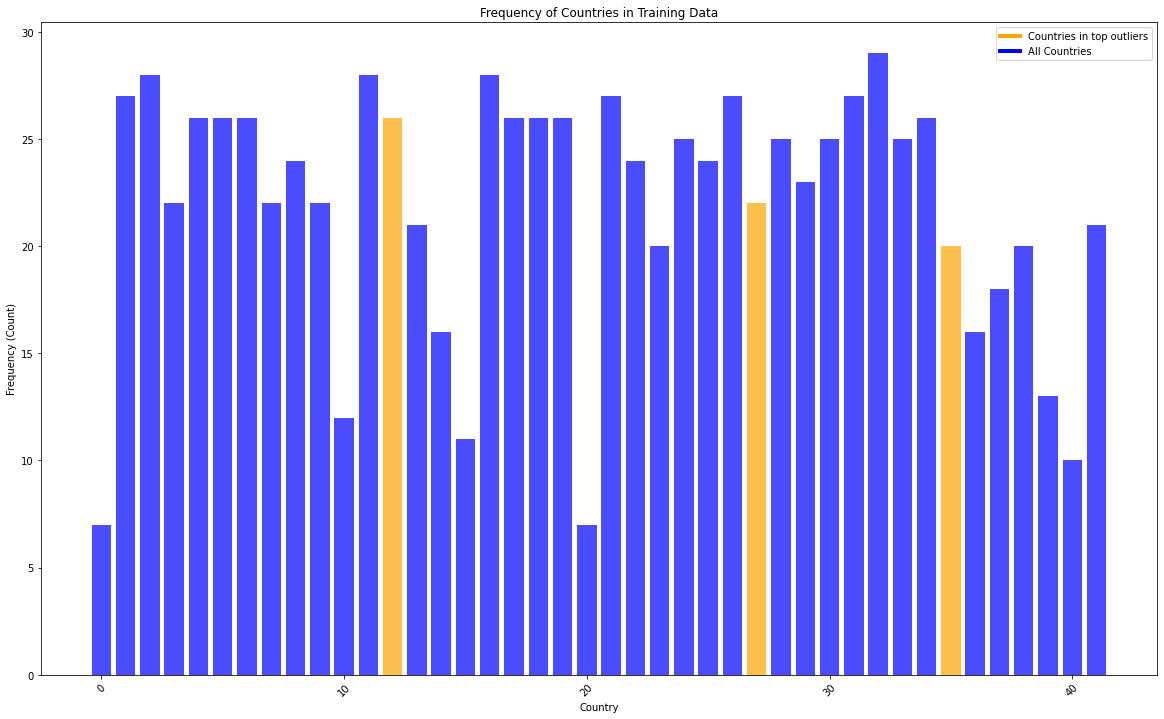

In [47]:
# Define the specific country to highlight in orange
highlight_countries = [35,12,27]

# Create a list of colors (use orange for the highlighted countries, blue for others)
colors = ['orange' if country in highlight_countries else 'blue' for country in train_country_counts.index]

# Create a bar plot
plt.figure(figsize=(20, 12))
plt.bar(train_country_counts.index, train_country_counts, color=colors, alpha=0.7)
plt.xlabel('Country')
plt.ylabel('Frequency (Count)')
plt.title('Frequency of Countries in Training Data')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Create a legend
legend_labels = ['Countries in top outliers', 'All Countries']
legend_handles = [plt.Line2D([0], [0], color='orange', lw=4), plt.Line2D([0], [0], color='blue', lw=4)]
plt.legend(legend_handles, legend_labels)

# Display the plot
plt.show()